## 导入模型

In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

In [2]:
# 神经网络配置
max_features = 40001
maxlen = 400
batch_size = 128
embedding_dims = 50
epochs = 8
vocab_size = 40000


In [3]:
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [4]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt 
plt.switch_backend('agg')
%matplotlib inline

In [5]:
import sys
from collections import Counter
import numpy as np
import tensorflow.keras as kr
import os

## 定义一些数据处理函数

In [6]:
def read_vocab(vocab_file):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open(vocab_file,mode='r',encoding='utf-8') as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 40000) for x in content]

def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

这是一些类型的转换

In [7]:
age_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}
gender_to_id = {1:0,2:1}
education_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}

In [8]:
vocab_file_age = './Data/VersonData_4/vocab_file_age.txt'
vocab_file_gender = './Data/VersonData_4/vocab_file_gender.txt'
vocab_file_education = './Data/VersonData_4/vocab_file_education.txt'

## 表征搭建

In [9]:
file_proce_path = './Data/VersonData_2/traindf.csv'
traindf = pd.read_csv(file_proce_path,encoding='utf-8')
traindf['Query List'] = traindf['Query List'].apply(lambda x:x.split(' '))
traindf.head()

,ID,Age,Gender,Education,Query List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,"[柔和, 双沟, 女生, 中财网, 首页, 财经, 周公, 解梦, 大全, 查询, 2345..."
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"[广州, 厨宝, 烤箱, 世情, 人情, 雨送, 黄昏, 花易落, 风干, 泪痕, 厦门, ..."
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,"[钻石, 之泪, 耳机, 盘锦, 沈阳, 旅顺, 公交, 辽宁, 阜新, 车牌, baidu..."
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,"[受欢迎, 狗狗, 排行榜, 场景, 范例, 三维, 绘图, 软件, 酸奶, 壮观, 衣服,..."
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,"[干槽症, 自愈, 太太, 万岁, 舒心, 美国, 干槽症, 眼皮, 怎么回事, 麦当劳, ..."


### age测试

In [10]:
agedf= traindf[['Age','Query List']]
agedf = agedf[agedf['Age']!=0]
X_age = agedf['Query List'].values.tolist()
Y_age = agedf['Age'].values.tolist()

In [11]:
age_words, age_word_to_id = read_vocab(vocab_file_age)

In [12]:
print(age_words[0:10])

['<PAD>', '图片', '手机', '小说', '视频', '下载', '大全', 'qq', '电影', '中国']


In [13]:
#数据打乱 
data = list(zip(X_age,Y_age))
del X_age,Y_age
random.shuffle(data)
X_age,Y_age = zip(*data)

In [14]:
datax_train, datax_test,datay_train,datay_test = train_test_split(X_age,Y_age,random_state =1)

In [15]:
x_train = encode_sentences([content for content in datax_train], age_word_to_id)
y_train = to_categorical(encode_cate(datay_train, age_to_id))
x_test = encode_sentences([content for content in datax_test], age_word_to_id)
y_test = to_categorical(encode_cate(datay_test, age_to_id))

In [16]:
print(x_train[0:20])

[[115, 27933, 1707, 42, 618, 260, 37946, 5765, 1402, 15082, 9481, 6549, 40000, 600, 6371, 66, 4433, 870, 6282, 40000, 40000, 1507, 3594, 1575, 1488, 5765, 1402, 15082, 9481, 2402, 10516, 1575, 115, 1544, 115, 7161, 17333, 3789, 15205, 40000, 870, 14637, 36, 7506, 40000, 618, 260, 2743, 40000, 115, 40000, 1349, 5765, 1402, 15082, 9481, 3891, 5765, 1402, 40000, 40000, 1422, 870, 1422, 5765, 1402, 15082, 9481, 1655, 7838, 714, 7732, 1304, 618, 260, 2743, 40000, 40000, 6524, 25009, 1, 6954, 618, 260, 2743, 706, 5765, 1402, 15082, 9481, 40000, 5765, 1402, 15082, 3891, 115, 40000, 7704, 173, 3592, 17333, 2023, 446, 173, 3592, 115, 5765, 1402, 15082, 9481, 40000, 40000, 864, 5765, 1402, 15082, 9481, 680, 8023, 5765, 1402, 15082, 9481, 27831, 40000, 5765, 1402, 15082, 9481, 1503, 3789, 15205, 40000, 4461, 2401, 5765, 1402, 15082, 9481, 27831, 40000, 762, 5765, 1402, 15082, 9481, 2551, 5765, 1402, 15082, 40000, 35893, 12230, 3789, 15205, 40000, 870, 6282, 762, 18, 6806, 5765, 1402, 15082, 9481,

In [18]:
# del datax_train,datax_test,datay_train,datay_test
# del x_train,y_train,x_test,y_test
# del agedf
# del X_age,Y_age

In [17]:
print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73750, 400)
x_test shape: (24584, 400)
y_test shape: (24584, 6)


In [18]:
print('构建模型...')
age_model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
age_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
# 设定callbacks回调函数
age_model_file = './Model/cnn_age3_model.h5'
my_callbacks = [
    ModelCheckpoint(age_model_file, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

In [20]:
# fit拟合数据
history = age_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train on 73750 samples, validate on 24584 samples
Epoch 1/8
73600/73750 [============================>.] - ETA: 0s - loss: 1.1681 - acc: 0.5325
Epoch 00001: saving model to ./Model/cnn_age3_model.h5
73750/73750 [==============================] - 17s 234us/sample - loss: 1.1678 - acc: 0.5326 - val_loss: 1.0794 - val_acc: 0.5759
Epoch 2/8
73600/73750 [============================>.] - ETA: 0s - loss: 0.9787 - acc: 0.6285
Epoch 00002: saving model to ./Model/cnn_age3_model.h5
73750/73750 [==============================] - 17s 226us/sample - loss: 0.9786 - acc: 0.6286 - val_loss: 1.0727 - val_acc: 0.5813
Epoch 3/8
73600/73750 [============================>.] - ETA: 0s - loss: 0.7892 - acc: 0.7208
Epoch 00003: saving model to ./Model/cnn_age3_model.h5
73750/73750 [==============================] - 16s 221us/sample - loss: 0.7892 - acc: 0.7207 - val_loss: 1.1357 - val_acc: 0.5702
Epoch 4/8
73728/73750 [============================>.] - ETA: 0s - loss: 0.5334 - acc: 0.8336
Epoch 00004: saving

In [21]:
def plt_show_loss(history):
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :CNN',fontsize=16)
    plt.show()

    
def plt_show_acc(history):
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : CNN',fontsize=16)
    plt.show() 

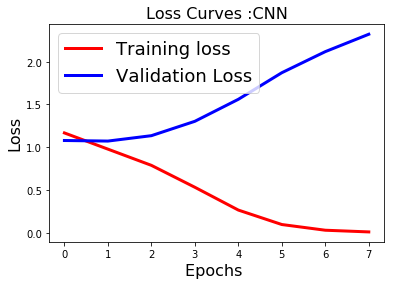

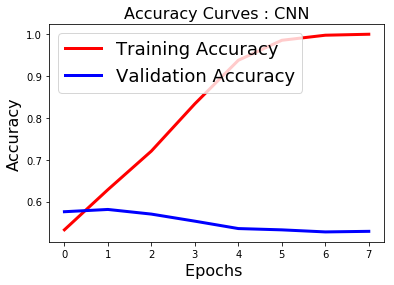

In [22]:
plt_show_loss(history)
plt_show_acc(history)

In [23]:
import gc

In [24]:
del datax_train,datax_test,datay_train,datay_test
del x_train,y_train,x_test,y_test
del agedf
gc.collect()

5167

### 改用分层抽样

In [25]:
from sklearn.model_selection import StratifiedKFold

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
stratifiedk_fold = StratifiedKFold(n_splits=5, shuffle=True)

In [28]:
npX = np.array(X_age)
npY = np.array(Y_age)

In [29]:
train_index=[] 
test_index = []
for ta_index,te_index  in stratifiedk_fold.split(npX, npY):
    train_index.append(ta_index)
    test_index.append(te_index)

In [30]:
x_train = npX[train_index[0]]
x_test = npX[test_index[0]]
y_train = npY[train_index[0]]
y_test = npY[test_index[0]]

In [31]:
xs_train = encode_sentences([content for content in list(x_train)], age_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), age_to_id))
xs_test = encode_sentences([content for content in list(x_test)], age_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), age_to_id))

In [32]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (78665, 400)
x_test shape: (19669, 400)
y_test shape: (19669, 6)


In [33]:
print('构建模型...')
age_model_sta = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
age_model_sta.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...


In [34]:
age_model_file = './Model/cnn_age4_model.h5'

In [35]:
# fit拟合数据
history_age = age_model_sta.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 78665 samples, validate on 19669 samples
Epoch 1/8
78464/78665 [============================>.] - ETA: 0s - loss: 1.1622 - acc: 0.5320
Epoch 00001: saving model to ./Model/cnn_age3_model.h5
78665/78665 [==============================] - 17s 222us/sample - loss: 1.1618 - acc: 0.5322 - val_loss: 1.0749 - val_acc: 0.5781
Epoch 2/8
78464/78665 [============================>.] - ETA: 0s - loss: 0.9769 - acc: 0.6294
Epoch 00002: saving model to ./Model/cnn_age3_model.h5
78665/78665 [==============================] - 17s 215us/sample - loss: 0.9768 - acc: 0.6294 - val_loss: 1.0647 - val_acc: 0.5820
Epoch 3/8
78464/78665 [============================>.] - ETA: 0s - loss: 0.7936 - acc: 0.7163
Epoch 00003: saving model to ./Model/cnn_age3_model.h5
78665/78665 [==============================] - 17s 216us/sample - loss: 0.7937 - acc: 0.7162 - val_loss: 1.1386 - val_acc: 0.5681
Epoch 4/8
78464/78665 [============================>.] - ETA: 0s - loss: 0.5463 - acc: 0.8253
Epoch 00004: saving

In [36]:
del x_train,x_test,y_train,y_test
del xs_train,xs_test,ys_train,ys_test
del npX,npY
del X_age,Y_age
del train_index,test_index

In [39]:
del age_words,age_word_to_id

In [40]:
gc.collect()

6268

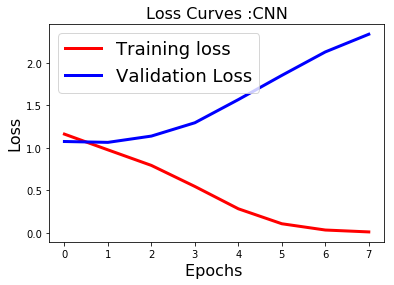

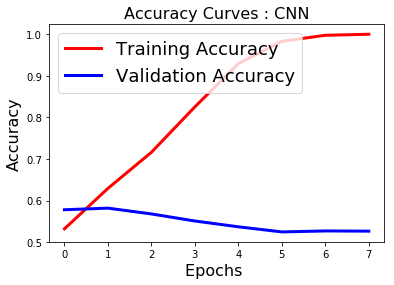

In [38]:
plt_show_loss(history_age)
plt_show_acc(history_age)

## 测试性别

In [41]:
genderdf = traindf[['Age','Query List','Gender']]
genderdf = genderdf[genderdf['Gender']!= 0]
X_gender = genderdf['Query List'].values.tolist()
Y_gender = genderdf['Gender'].values.tolist() 
Y_ageflg = genderdf['Age'].values.tolist() 

In [42]:
gender_words, gender_word_to_id = read_vocab(vocab_file_gender)

In [43]:
npX_gender = np.array(X_gender)
npY_gender = np.array(Y_gender)
npY_ageflg = np.array(Y_ageflg)

In [44]:
train_index_gender=[] 
test_index_gender = []
for ta_index,te_index  in stratifiedk_fold.split(npX_gender, npY_ageflg):
    train_index_gender.append(ta_index)
    test_index_gender.append(te_index)

In [45]:
x_train = npX_gender[train_index_gender[0]]
x_test = npX_gender[test_index_gender[0]]
y_train = npY_gender[train_index_gender[0]]
y_test = npY_gender[test_index_gender[0]]

In [46]:
xs_train = encode_sentences([content for content in list(x_train)], gender_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), gender_to_id))
xs_test = encode_sentences([content for content in list(x_test)], gender_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), gender_to_id))

In [47]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (78273, 400)
x_test shape: (19572, 400)
y_test shape: (19572, 2)


In [48]:
print('构建模型...')
gender_model = TextCNN(maxlen, max_features, embedding_dims,class_num=2).get_model()
gender_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
gender_model_file = './Model/cnn_gender_model.h5'

构建模型...


In [49]:
# fit拟合数据
history_gender = gender_model.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 78273 samples, validate on 19572 samples
Epoch 1/8
78208/78273 [============================>.] - ETA: 0s - loss: 0.4756 - acc: 0.7910
Epoch 00001: saving model to ./Model/cnn_age3_model.h5
78273/78273 [==============================] - 18s 232us/sample - loss: 0.4756 - acc: 0.7910 - val_loss: 0.4374 - val_acc: 0.8276
Epoch 2/8
78208/78273 [============================>.] - ETA: 0s - loss: 0.3722 - acc: 0.8555
Epoch 00002: saving model to ./Model/cnn_age3_model.h5
78273/78273 [==============================] - 17s 219us/sample - loss: 0.3721 - acc: 0.8556 - val_loss: 0.4510 - val_acc: 0.8212
Epoch 3/8
78208/78273 [============================>.] - ETA: 0s - loss: 0.2634 - acc: 0.9022
Epoch 00003: saving model to ./Model/cnn_age3_model.h5
78273/78273 [==============================] - 17s 215us/sample - loss: 0.2635 - acc: 0.9022 - val_loss: 0.5061 - val_acc: 0.8033
Epoch 4/8
78208/78273 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9659
Epoch 00004: saving

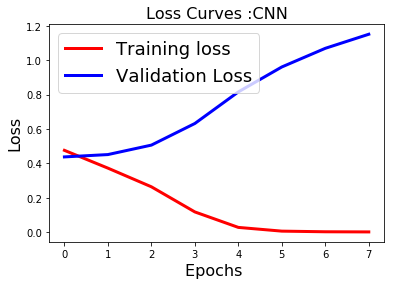

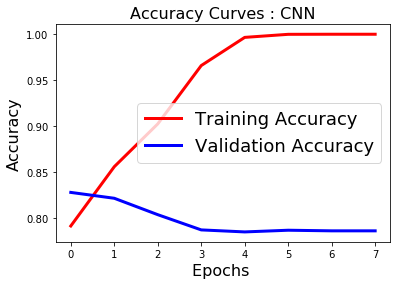

In [51]:
plt_show_loss(history_gender)
plt_show_acc(history_gender)

In [52]:
del x_train,x_test,y_train,y_test
del xs_train,xs_test,ys_train,ys_test
del train_index_gender,test_index_gender
del npX_gender, npY_gender, npY_ageflg 
del X_gender,Y_gender,Y_ageflg
del genderdf
del gender_words, gender_word_to_id

In [53]:
gc.collect()

11684

## 测试学历

In [54]:
educationdf = traindf[['Education','Query List']]
educationdf = educationdf[educationdf['Education']!=0]
X_education = educationdf['Query List'].values.tolist()
Y_education = educationdf['Education'].values.tolist() 

In [55]:
education_words, education_word_to_id = read_vocab(vocab_file_education)

In [56]:
npX_education = np.array(X_education)
npY_education = np.array(Y_education)

In [57]:
train_index_education=[] 
test_index_education = []
for ta_index,te_index  in stratifiedk_fold.split(npX_education, npY_education):
    train_index_education.append(ta_index)
    test_index_education.append(te_index)

In [58]:
x_train = npX_education[train_index_education[0]]
x_test = npX_education[test_index_education[0]]
y_train = npY_education[train_index_education[0]]
y_test = npY_education[test_index_education[0]]

In [59]:
xs_train = encode_sentences([content for content in list(x_train)], education_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), education_to_id))
xs_test = encode_sentences([content for content in list(x_test)], education_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), education_to_id))

In [60]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (72574, 400)
x_test shape: (18146, 400)
y_test shape: (18146, 6)


In [61]:
print('构建模型...')
education_model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
education_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
education_model_file = './Model/cnn_education_model.h5'

构建模型...


In [62]:
# fit拟合数据
history_education = education_model.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 72574 samples, validate on 18146 samples
Epoch 1/8
72320/72574 [============================>.] - ETA: 0s - loss: 1.0742 - acc: 0.5558
Epoch 00001: saving model to ./Model/cnn_age3_model.h5
72574/72574 [==============================] - 16s 223us/sample - loss: 1.0737 - acc: 0.5560 - val_loss: 0.9984 - val_acc: 0.5935
Epoch 2/8
72320/72574 [============================>.] - ETA: 0s - loss: 0.8930 - acc: 0.6557
Epoch 00002: saving model to ./Model/cnn_age3_model.h5
72574/72574 [==============================] - 16s 220us/sample - loss: 0.8930 - acc: 0.6557 - val_loss: 0.9789 - val_acc: 0.6083
Epoch 3/8
72320/72574 [============================>.] - ETA: 0s - loss: 0.7106 - acc: 0.7444
Epoch 00003: saving model to ./Model/cnn_age3_model.h5
72574/72574 [==============================] - 16s 219us/sample - loss: 0.7107 - acc: 0.7443 - val_loss: 1.0479 - val_acc: 0.6002
Epoch 4/8
72320/72574 [============================>.] - ETA: 0s - loss: 0.4693 - acc: 0.8521
Epoch 00004: saving

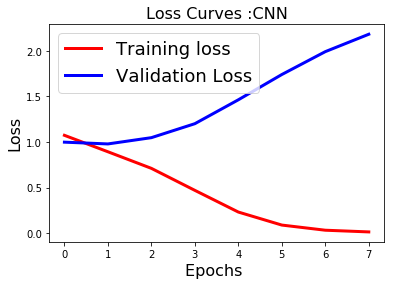

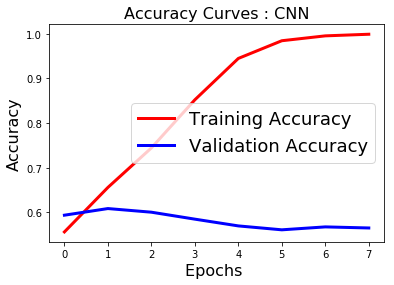

In [63]:
plt_show_loss(history_education)
plt_show_acc(history_education)

## 总结 
cnn的结果总体要比Nb 好一点，  
但是之后还需要处理的问题：   
        &emsp;&emsp;&emsp;过拟合  
         &emsp;&emsp;&emsp;参数调优  
          &emsp;&emsp;&emsp;模型获取